In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install lmfit
clear_output()

In [ ]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import LinearModel, LorentzianModel

In [ ]:
if os.path.isdir("/content/heterodyne/") and os.path.isdir("/content/split_detection/"):
    pass
else:
    !unzip /content/drive/MyDrive/allan_data/heterodyne.zip
    !unzip /content/drive/MyDrive/allan_data/split_detection.zip
clear_output()

In [ ]:
# Processing functions

def columns_to_array(df):
    """
    Create individual numpy arrays from columns of a data frame

    Args:
    df (pd.DataFrame):  The data frame to convert

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """
    result = []
    for _, col_data in df.iteritems():
        result.append(col_data.values)
    return result

def load_csv_file(fpath, spectra_units):
    """
    Load a single csv file into memory as a pandas.DataFrame
    
    Args:
    fpath (str):  The relative path to the csv file

    spectra_units (str):  Units to use for the spectra values.
                          Typically m^2/Hz or V^2/Hz.
    """
    return pd.read_csv(fpath, names=["Frequency (Hz)", f"Spectra ({spectra_units})"])

def process_csv_file(fpath, spectra_units):

    """
    Load a single CSV file into memeory as numpy arrays

    Args:
    fpath (str):  The relative path to the binary file

    vec (np.array):  A column vector

    Returns:
    tuple(np.array, ... np.array):  The columns of `df` as elements of a tuple.
                                    Length of tuple depends on number of columns.
    """

    df = load_csv_file(fpath, spectra_units)

    return columns_to_array(df)

def match_filenames_in_dir(pattern, dirpath):

    """
    Search a directory tree for all filenames which match a specified pattern

    Args:
    pattern (str):  Expression for the filename template
    directory(str):  Path to directory where data files are located

    Returns:
    (list(str)):  List of all the filenames which match a specified pattern
    """

    # List of all found files that match pattern
    result = []
    # Walk the tree
    for root, dirs, files in os.walk(dirpath):
        # Only care about files within the directory
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [ ]:
def sort_key(filepath):
    """
    Find the file number from the path to a file
    """

    filename = filepath.split('/')[-1]
    filenumber = filename.split('_')[-1].strip(".CSV")
    return int(filenumber)

In [ ]:
def super_plot(pattern, directory, title, units="m^2/Hz"):

    """
    Superimpose spectra onto a single plot
    """
    
    # Get a list of files
    filepaths = match_filenames_in_dir(pattern, directory)
    filepaths.sort(key=sort_key)
    
    # Set up a single figure 
    fig = plt.figure()
    ax = fig.add_subplot(111, title=title, xlabel="Frequency (Hz)", ylabel=f"Spectra ({units})")

    # Add lines to the figure
    for path in filepaths:
        df = load_csv_file(path, f"{units}")
        freq = df["Frequency (Hz)"]
        spectra = df[f"Spectra ({units})"]
        ax.plot(freq, spectra)
    
    plt.show()
    return 

In [ ]:
het = {"pattern":"het_st80_*.CSV",
       "directory":"/content/heterodyne/",
       "title":"Heterodyne",
       "units":"V^2/Hz"}

cha = {"pattern":"cha_st80_*.CSV",
       "directory":"/content/split_detection/",
       "title":"Channel A Sideband",
       "units":"m^2/Hz"}

chb = {"pattern":"chb_st80_*.CSV",
       "directory":"/content/split_detection/",
       "title":"Channel B Sideband",
       "units":"m^2/Hz"}


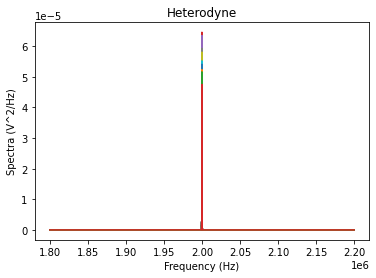

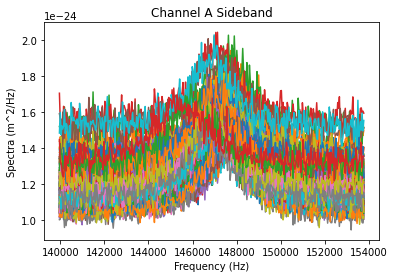

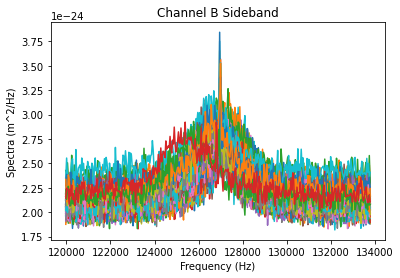

In [ ]:
for data in [het, cha, chb]:
    super_plot(data["pattern"], data["directory"], data["title"], data["units"])
    print("\n")

# Lorentzian Fit

In [ ]:
het1 = load_csv_file(het["directory"]+"het_st80_1.CSV", het["units"])
freq = het1["Frequency (Hz)"]
spectra = het1["Spectra (V^2/Hz)"]

model = LorentzianModel()

pars = model.guess(spectra, x=freq)
out = model.fit(spectra, pars, x=freq)

print(out.fit_report(min_correl=0.25))

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 10487
    # variables        = 3
    chi-square         = 1.2650e-11
    reduced chi-square = 1.2066e-15
    Akaike info crit   = -360235.582
    Bayesian info crit = -360213.808
[[Variables]]
    amplitude:  0.00112338 +/- 4.4162e-06 (0.39%) (init = 2.442212)
    center:     1999905.78 +/- 0.12687906 (0.00%) (init = 1999893)
    sigma:      31.7402351 +/- 0.22606654 (0.71%) (init = 66668.2)
    fwhm:       63.4804701 +/- 0.45213308 (0.71%) == '2.0000000*sigma'
    height:     1.1266e-05 +/- 5.8334e-08 (0.52%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.250)
    C(amplitude, sigma) = 0.703
    C(center, sigma)    = -0.468
